# Loading Image

The input image is loaded using cv2.imread() function.
If you are using mpimg.imread() there might be some problems during histogram equalisation. and OTSu thresholding as they need the datatype to be CV_8UC1 format. So make necessary chnages to avoid these errors.



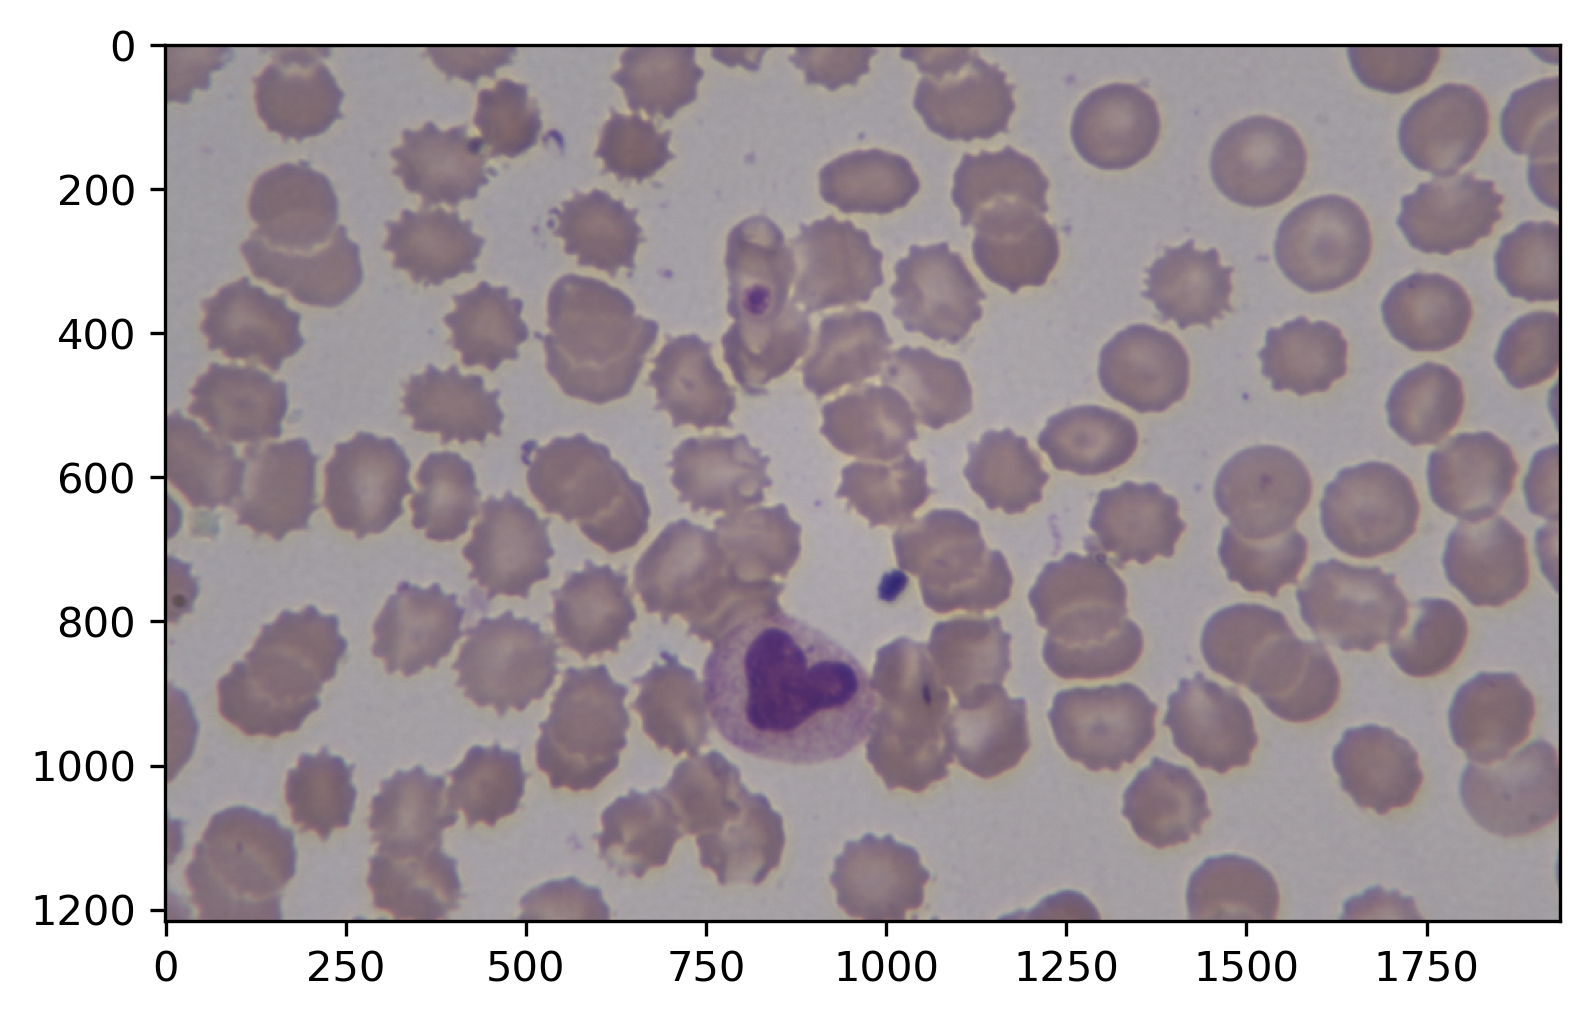

In [17]:
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from PIL import Image
import os
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#loading images
org=mpimg.imread('/home/priyanka/Desktop/Dataset/Dataset0001.bmp')
img =mpimg.imread('/home/priyanka/Desktop/Dataset/Dataset0001.bmp')

plt.imshow(img)
plt.show()


# PreProcessing
## 1. Gray Scale Conversion

As we are classifying R.B.Cs based on their appearances, it is not necessary to use color images. So, at first images are converted from RGB to grayscale images

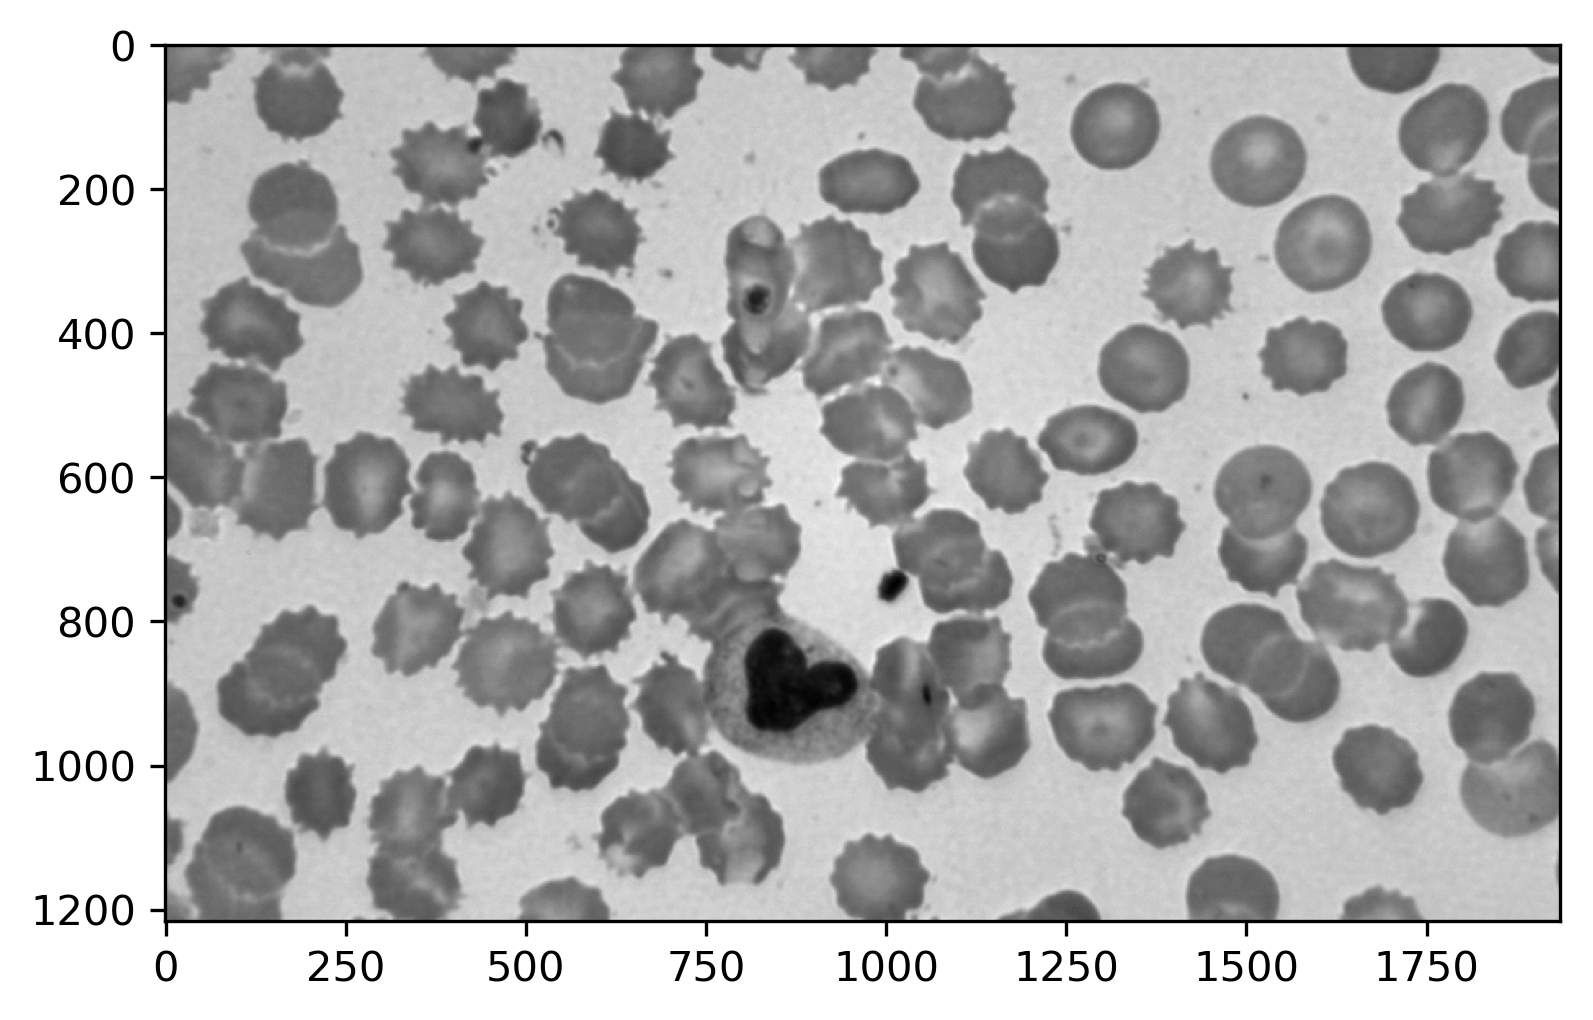

In [5]:
imGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(imGray, cmap="gray")

## 2. Histogram Equalisation

To enhance the grayscale histogram, it is necessary to
expand the gray levels to increase the contrast of foreground
cells from background of images

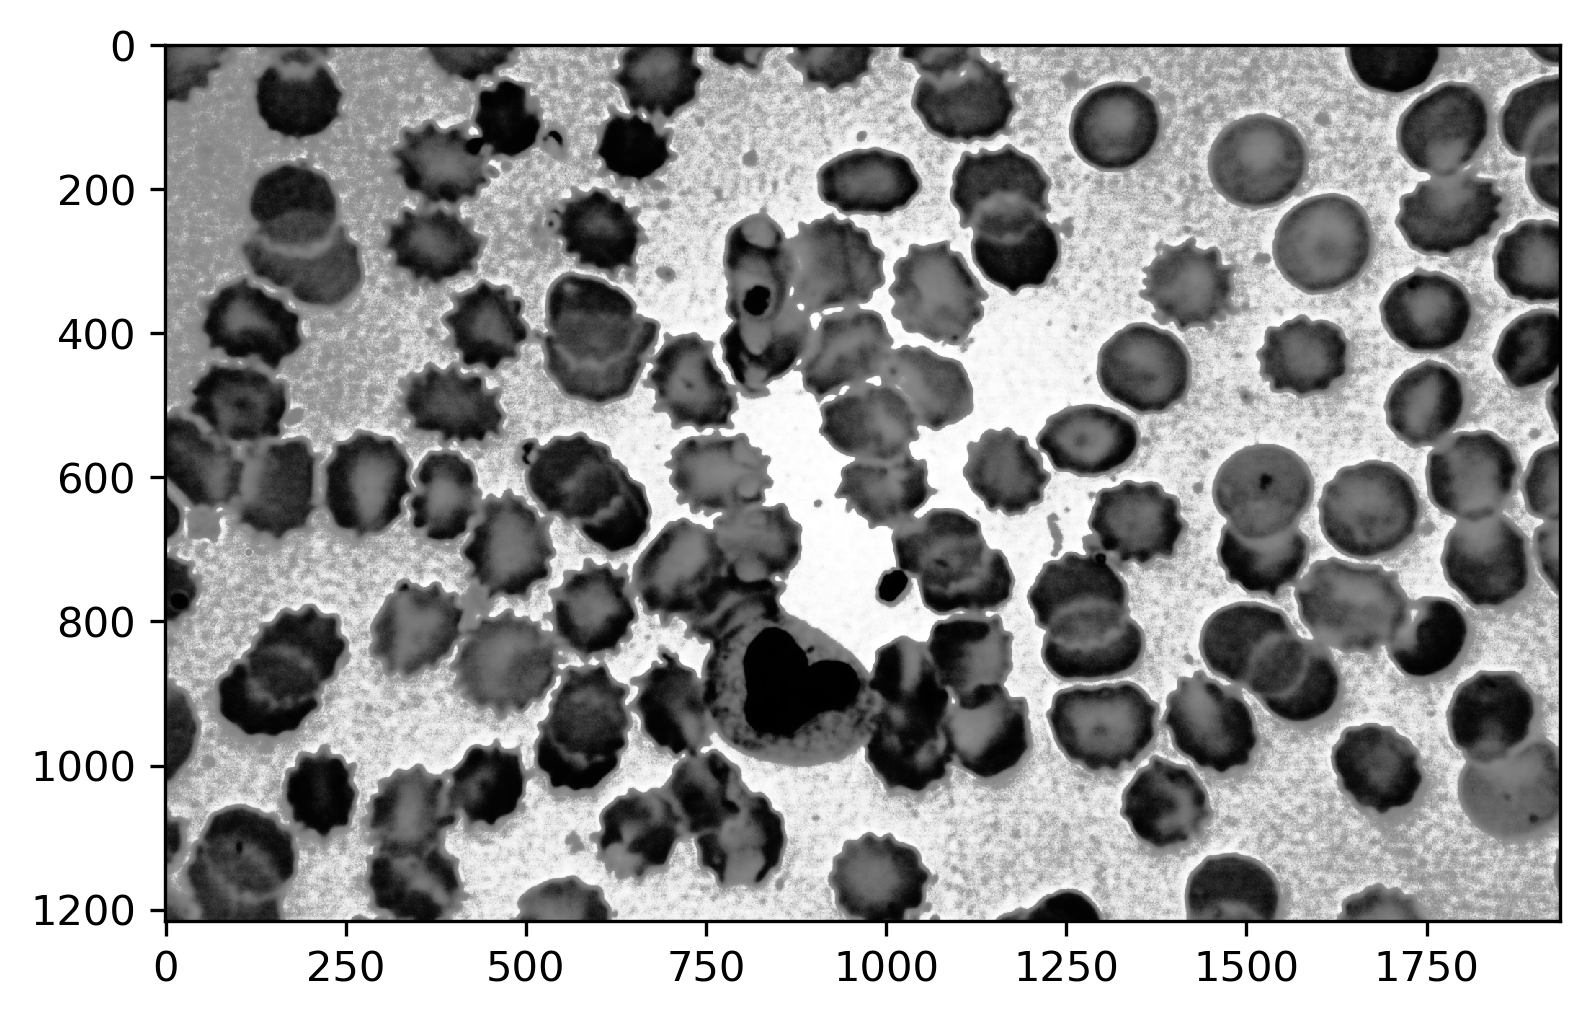

In [6]:
equ = cv2.equalizeHist(imGray)
plt.imshow(equ, cmap="gray")

## Gaussian Blurring

Microscopic images usually have noise and undesirable spots. With low pass filters, we can reduce some noises. As our feature extraction method is based on cell’s edge, using
a low pass Gaussian filter with minimum ringing effect may reduce noise

In the blur function below  the output image after hist equalisation should be used 

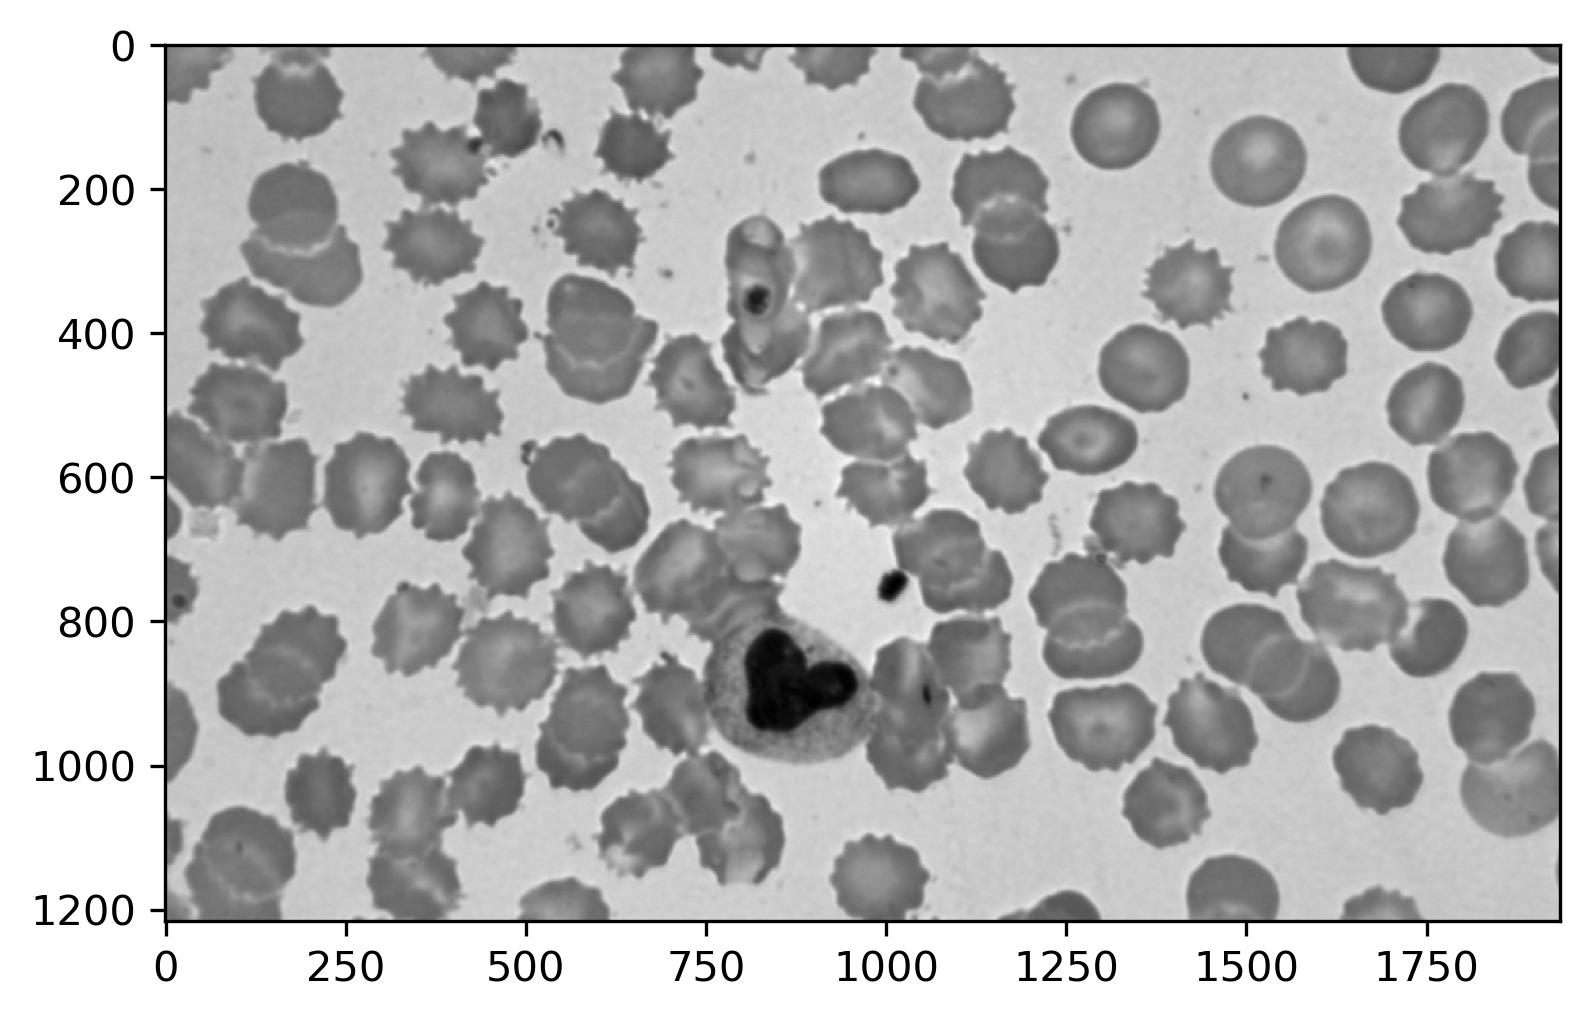

In [8]:
blur = cv2.GaussianBlur(org[:,:,1],(5,5),0)
plt.imshow(blur, cmap="gray")
plt.show()

## RBC Segmentation

The image segmentation process is mainly implemented to partition an image into a region of homogenous representation corresponds to the object of interest in the image. Overall performance of an automated RBC classification system is considerably depends on its ability to segment the RBC region in the observed image accurately. A subsequent action, such as analyzing or identifying objects, requires an accurate extraction of the foreground objects, making the image segmentation a crucial part of the system. Otsu adaptive threshold strategy is applied in the green channel of the RBC image to separating between two classes of
region. This method works by finding threshold value that minimizes the weighted within class variance. Sample of the produced binary image as a result of Otsu segmentation process is shown below


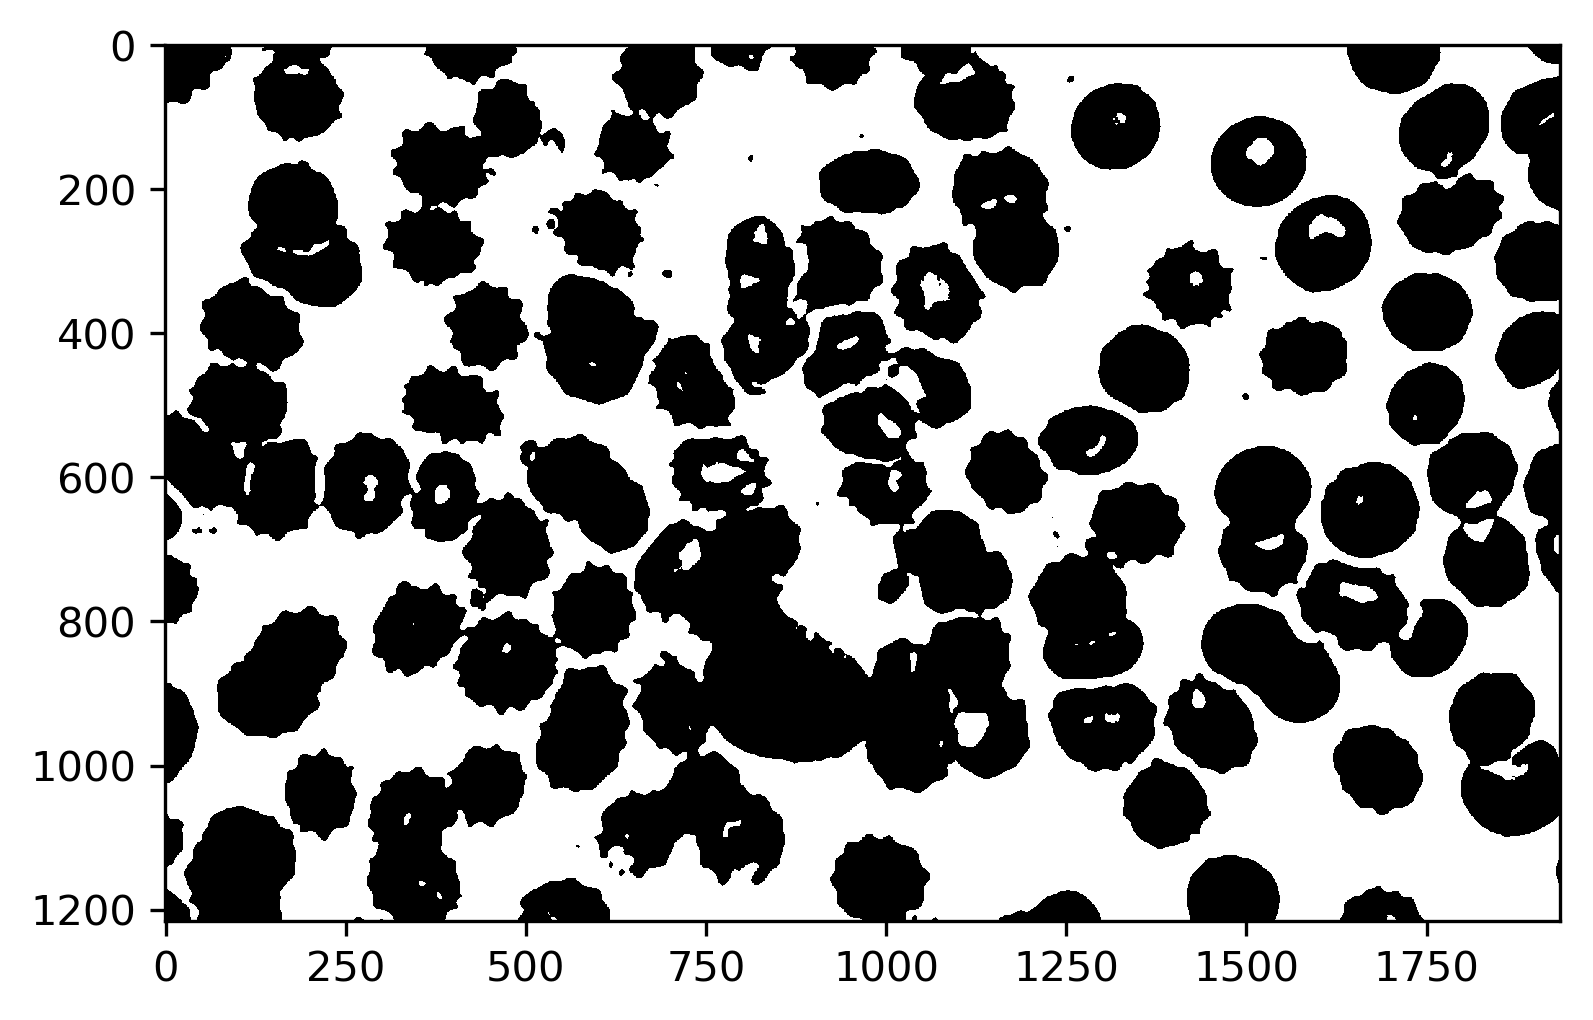

In [9]:
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3, cmap="gray")

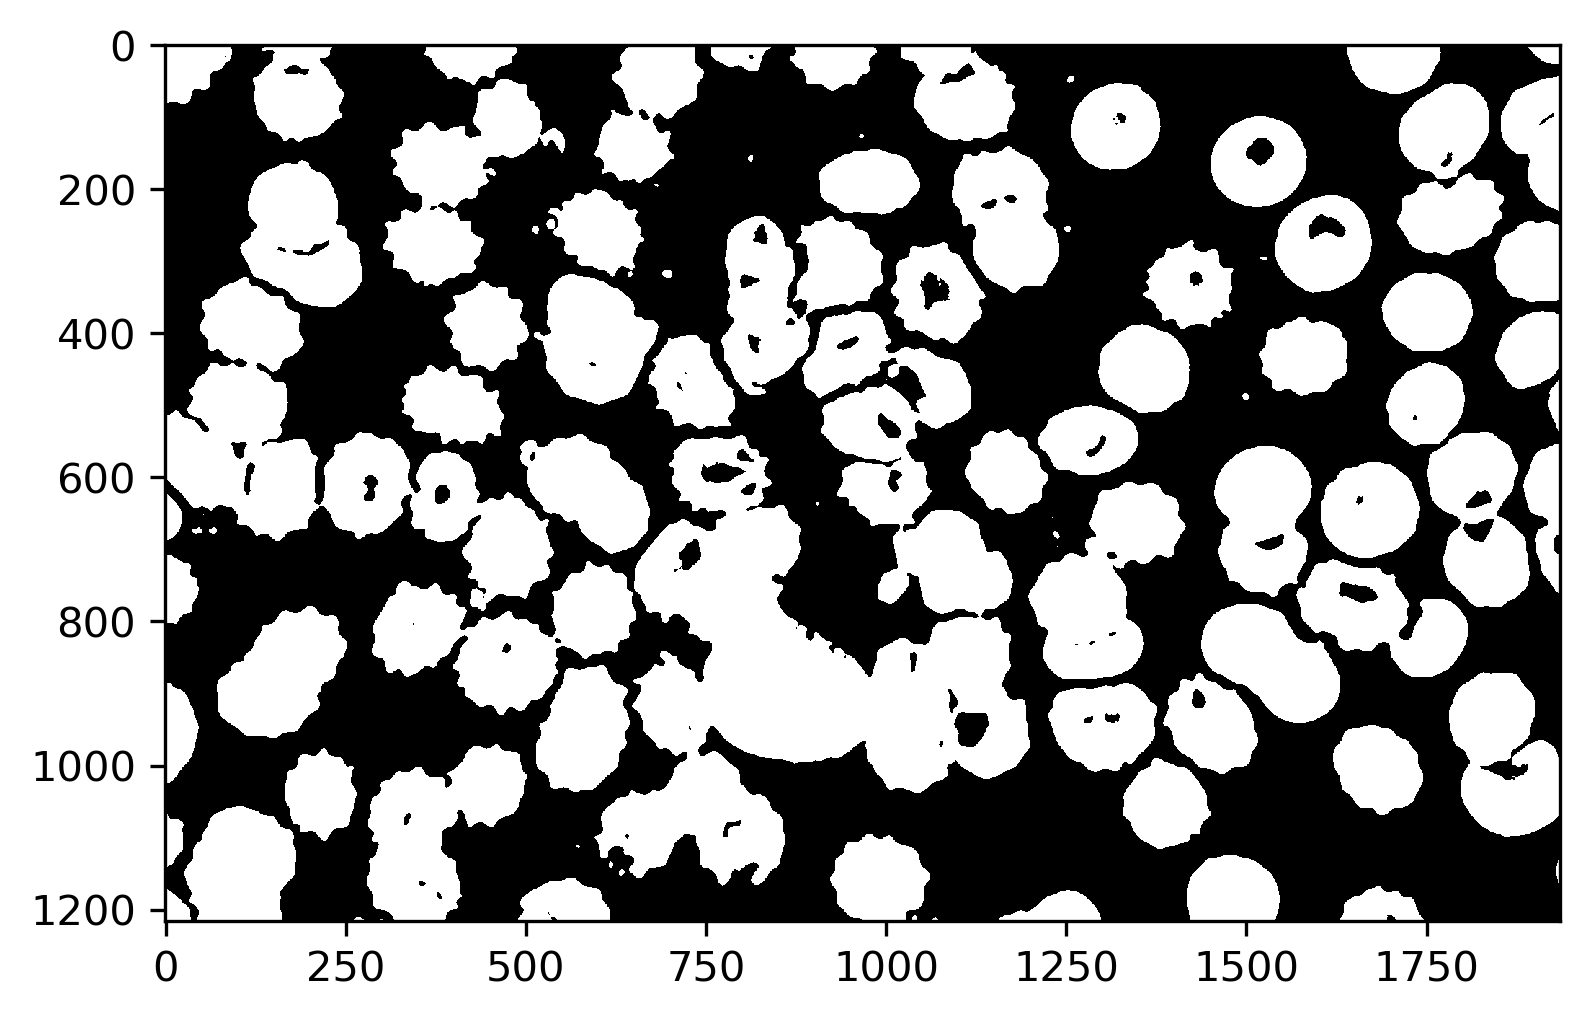

In [10]:
invert = cv2.bitwise_not(th3)
plt.imshow(invert, cmap="gray")

## Morphological Processing

Morphological operation works on binary image to change the size, shape, structure and connectivity of objects by using a structuring element and a set operator define by Erosion and Dilation. Erosion plays the role to ‘shrinks’ and ‘thins’ objects in image while dilation used to ‘grows’ and ‘thickens’ objects in image. The combination of both
operators can be use to removes, break connection, clearing border and filling up holes. In this project, a sequence of two times of Erosion, two times of Dilation and contour filling algorithm is used to diminish the small noise and
holes inside the cell.


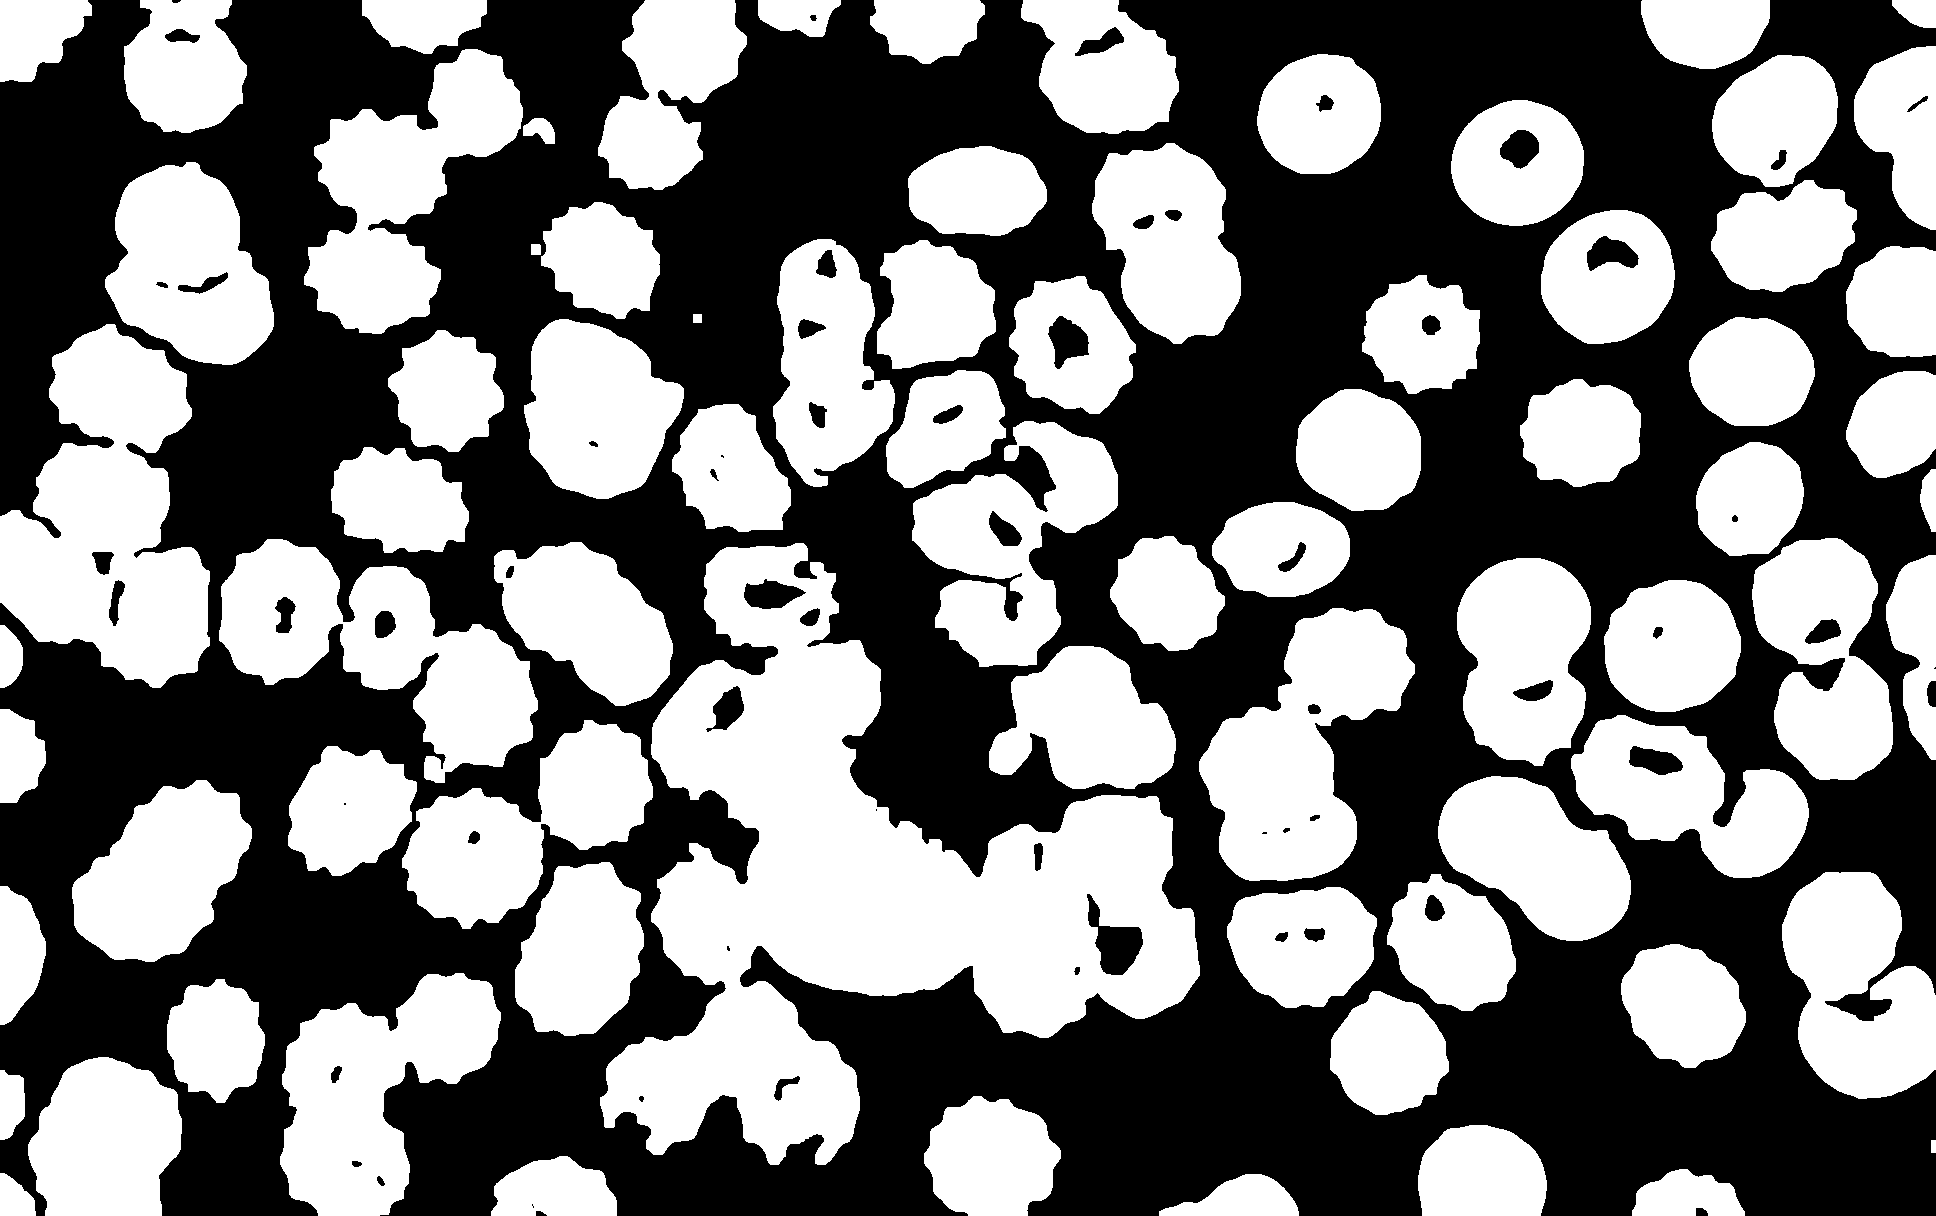

In [11]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(invert,kernel,iterations = 2)
opening = cv2.dilate(erosion,kernel,iterations = 2)

Image.fromarray(opening)

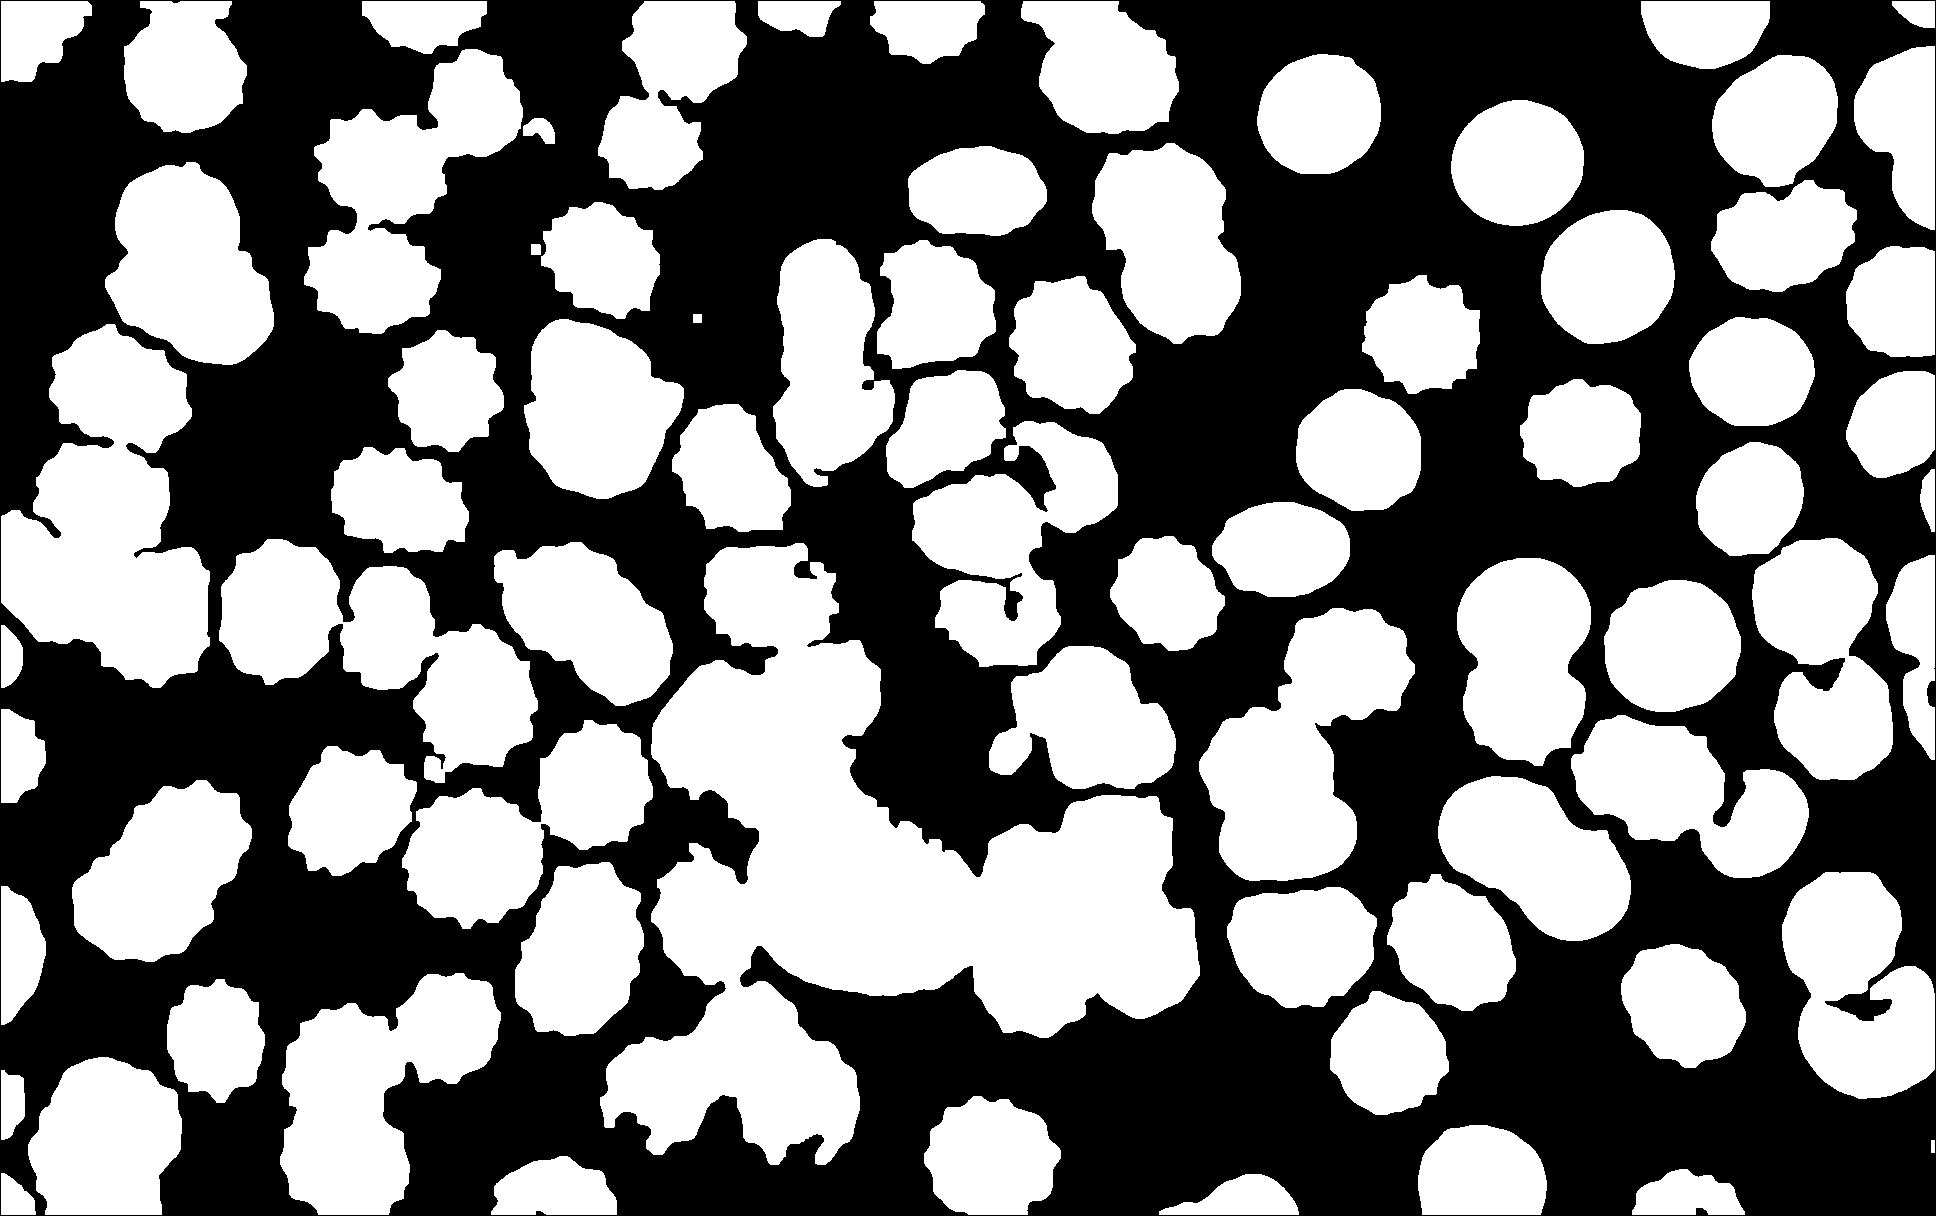

In [12]:
im2, contours, hierarchy = cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(opening,[cnt],0,255,-1)
Image.fromarray(opening)    
    

## Connected Components Labelling and Watershed Algorithm

In a blood image, there is condition where cells might be overlapped or clumped  more  than  two cells. To overcome that problem first CCL is applied and followed by watershed segmenation. 

In watershed segmentation an image is regarded as a topographic landscape with ridges and valleys. The elevation values of the landscape are typically defined by the gray values of the respective pixels or their gradient magnitude. Based on such a 3D representation the watershed transform decomposes an image into catchment basins. For each local minimum, a catchment basin comprises all points whose path of steepest descent terminates at this minimum. Watersheds separate basins from each other. The watershed transform decomposes an image completely and thus assigns each pixel either to a region or a watershed. With noisy medical image data, a large number of small regions arises. This is known as the “over-segmentation” problem.



In [13]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(opening)
localMax = peak_local_max(D, indices=False, min_distance=10,labels=opening)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=opening)
print("[No of unique segments found] {} ".format(len(np.unique(labels)) - 1))

[No of unique segments found] 133 


# Classification of RBC

here I have used two features to mainly classify the objects present in the image

1. Roundness <br>
    Roundness describes the level of cellular  roundness.  Roundness  is  the  ratio  between  object  area  and  squared  perimeter,  which  can  be  calculated using equation (13). The result is a value of  ≤ 1. Value 1indicates R object as a circle.
    $R = 2\pi\frac{Area}{Perimeter^{2}}$ <br>
2. Variance of distances of each pixel on edge from the cente
    The centre of mass of each object is calculated and the euclidean distacne from  each pixel on the edge to centre is calculated. Now the variances of these distances are taken.
    
Intially the roundness of the object is calculated and if the roundness falls in the range of [0.9, 1] then the object is classified as circle. <br>
If the Roundnes falls in the range [0 ,0.8] then the variance of the the distances are calculated. based on the variances again the objects are classified into either Unidentified, ellipitical, WBC <br>

The following are used to label the objects <br>
1. circle----->circular RBC <br>
2. elli-------->Elliptical RBC <br>
3. unid-------->unidentified <br>
4. wbc--------->wbc <br>

   


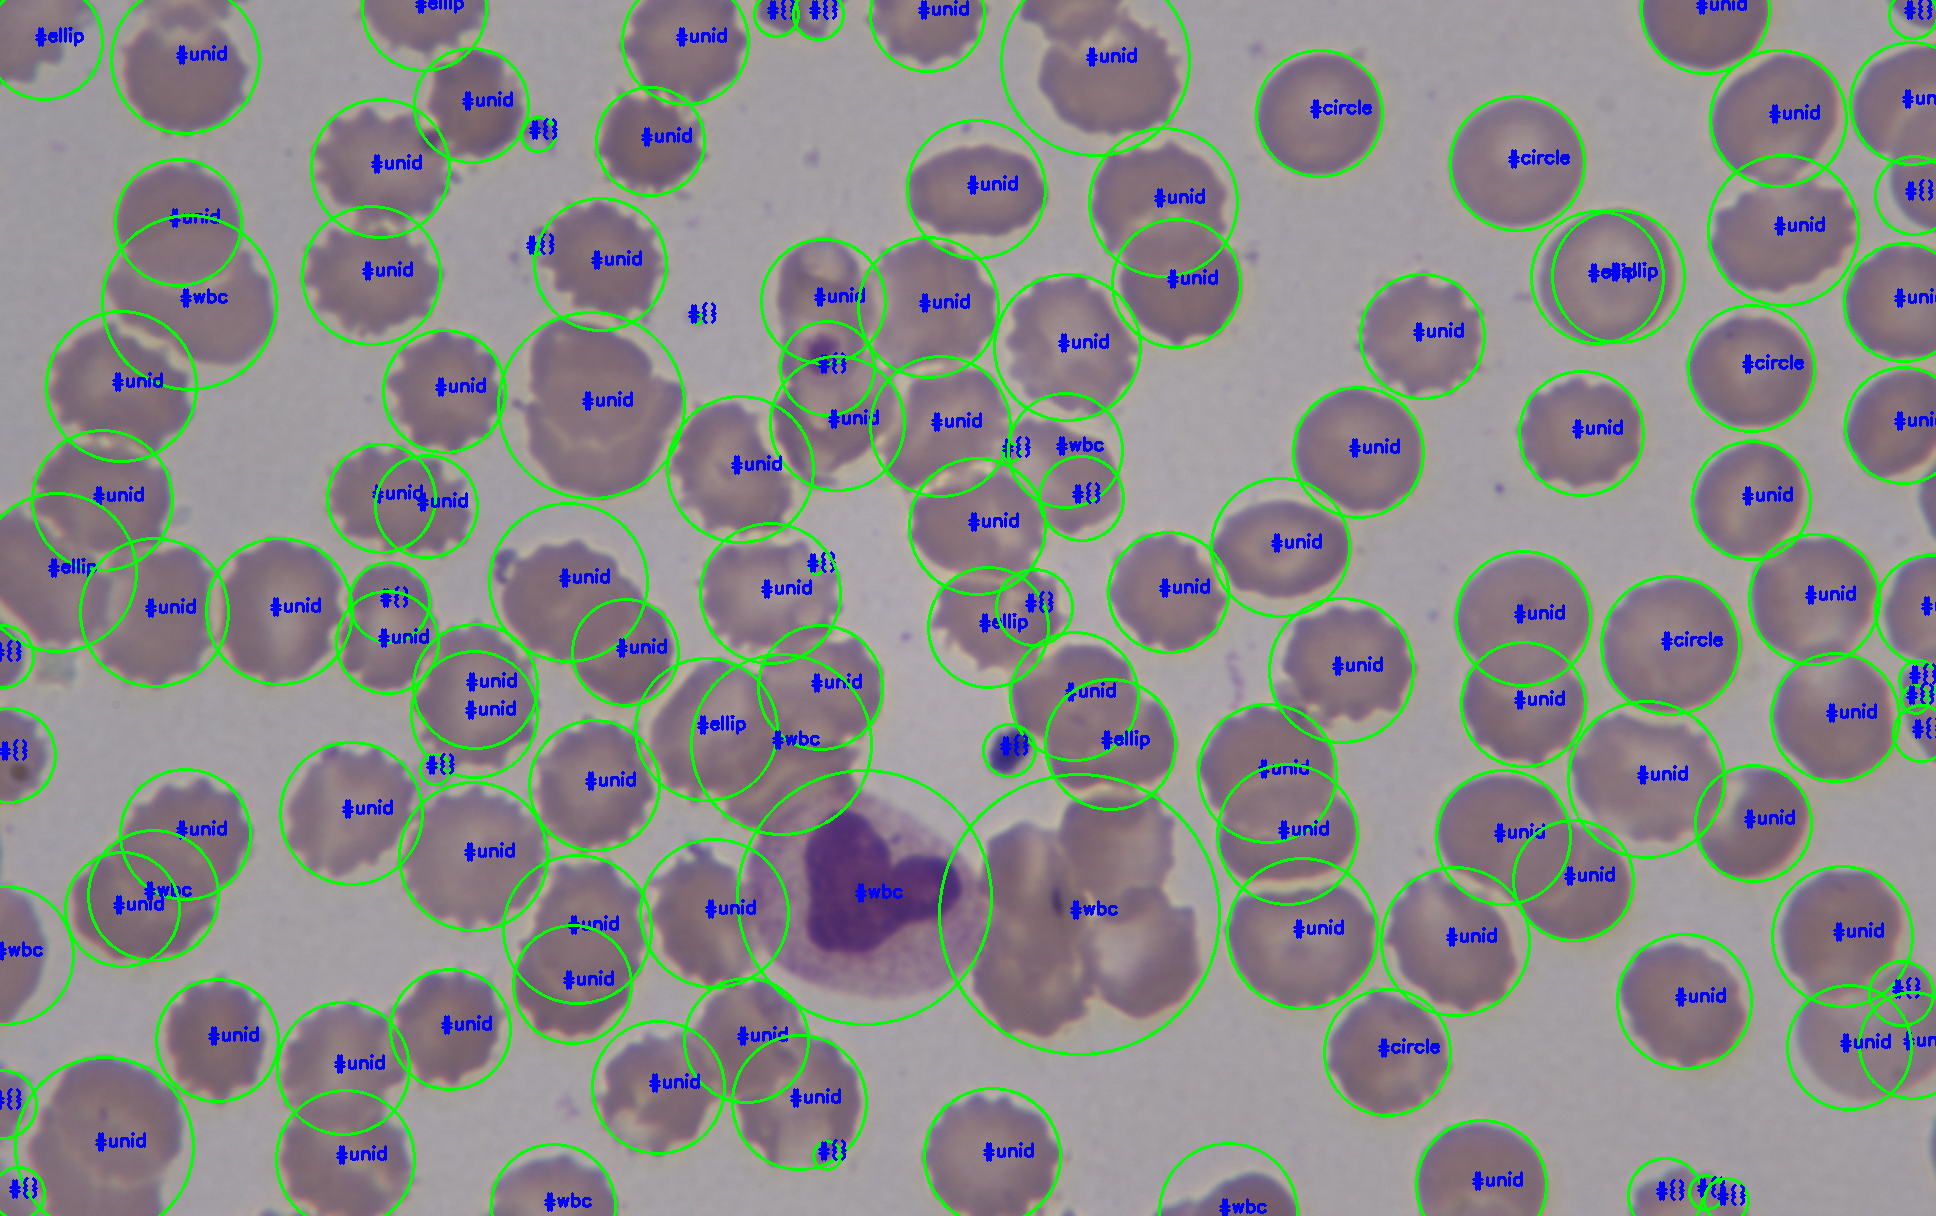

In [16]:
# loop over the unique labels returned by the Watershed
# algorithm
test=org
from scipy.spatial import distance
q=np.zeros(len(np.unique(labels)))
l=np.zeros(len(np.unique(labels)))
for label in np.unique(labels):
    j=1
    
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(imGray.shape, dtype="uint8")
    mask[labels == label] = 255
    
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
    M = cv2.moments(c)
    if M['m00']==0:
        M['m00']=1
        
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    b=[cx,cy]
    k=len(c)
    p=np.zeros(k)
    for i in range(k):
        p[i]=distance.euclidean(c[i], b)
    q[label]=np.var(p)
    perimeter = cv2.arcLength(c,True)
    area = cv2.contourArea(cnt)
    R=4*np.pi*area/np.square(perimeter)
    
    mark={}
    
    if R > 0.9 and R<1:
        if np.var(p)>1 and np.var(p)<7:
            mark="circle"
            
    elif R <0.9:
        if np.var(p)>1 and np.var(p)<7:
            mark="circle"
        elif np.var(p)>7 and np.var(p)<100:
            mark="unid"
        elif np.var(p)>100 and np.var(p)<130:
            mark="ellip"
        
        else:
            mark="wbc"
            
   
    
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(org, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(org, "#{}".format(mark), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
Image.fromarray(test)




References

I have used mainly these 2 papers to do this assignment specifically to get the knowledge about the variance values of different types of Rbc's <br>

1. Classification of three types of red blood cells in peripheral blood smear based on morphology 

2. Computer Aided System for Red Blood Cell Classification in Blood Smear Image